In [15]:
import glob
import os
import string

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [16]:
!pip install tensorflow

     |████████████████████████████████| 454.4 MB 106 kB/s  eta 0:00:011   |█████▉                          | 82.7 MB 42.0 MB/s eta 0:00:09
     |████████████████████████████████| 129 kB 24.3 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 76.1 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 60.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 93.3 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 8.3 MB/s  eta 0:00:01
     |████████████████████████████████| 6.0 MB 82.2 MB/s eta 0:00:01
     |████████████████████████████████| 4.0 MB 73.5 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 8.3 MB/s  eta 0:00:01
     |████████████████████████████████| 4.9 MB 60.1 MB/s eta 0:00:01
     |████████████████████████████████| 288 kB 108.0 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 20.6 MB/s eta 0:00:01
     |███████████████████████████████

### Load Data

The names can be found in text files in a src directory, one file per language.

In the following you can find some utilities to load the data into pandas data frames. 

We will restrict to some common European languages. 

With the given selection, we will identify all the occurring characters and initialize an alphabet.<br>
For this alphabet, we will use a one-hot-encoding to map them into a vector space representation. 

Foresee a suitable character for the end of the word, e.g. 'END'.

In [2]:
srcdir = 'data/names'
languages = ["English","French","Italian","German","Spanish"]

In [3]:
# inspect the data directory
def findFiles(path): 
    return glob.glob(path)

In [4]:
print('\n'.join(findFiles(os.path.join(srcdir,'*.txt'))))

data/names/Portuguese.txt
data/names/Chinese.txt
data/names/Vietnamese.txt
data/names/Scottish.txt
data/names/French.txt
data/names/Irish.txt
data/names/English.txt
data/names/German.txt
data/names/Korean.txt
data/names/Czech.txt
data/names/Polish.txt
data/names/Russian.txt
data/names/Greek.txt
data/names/Arabic.txt
data/names/Dutch.txt
data/names/Japanese.txt
data/names/Spanish.txt
data/names/Italian.txt


In [5]:
# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

def load_data(srcdir, categories=None):
    names_list = []
    for filename in findFiles(os.path.join(srcdir,'*.txt')):
        category = os.path.splitext(os.path.basename(filename))[0]
        if not categories or category in categories: 
            names = readLines(filename)
            names_list.extend([(name,category) for name in names])
    df = pd.DataFrame(names_list)
    df.columns = ["name","lang"]
    return df

In [6]:
names = load_data(srcdir,categories=languages)
names.head()

,name,lang
0,Abel,French
1,Abraham,French
2,Adam,French
3,Albert,French
4,Allard,French


In [7]:
maxlen = np.max([len(name) for name in names.name])
print("Maximum name length: ", maxlen)

Maximum name length:  18


In [8]:
alphabet = sorted(list(set(''.join([name for name in names.name]))))
alphabet.append('END')
len_alphabet = len(alphabet)
char_index = dict((c, i) for i, c in enumerate(alphabet))
print("Size of alphabet: ", len_alphabet)
print(alphabet)

Size of alphabet:  74
[' ', "'", 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'Á', 'É', 'ß', 'à', 'á', 'ä', 'ç', 'è', 'é', 'ê', 'ì', 'í', 'ñ', 'ò', 'ó', 'ö', 'ù', 'ú', 'ü', 'END']


In [9]:
names.groupby('lang')['name'].count()/len(names)

lang
English    0.646230
French     0.048802
German     0.127555
Italian    0.124912
Spanish    0.052502
Name: name, dtype: float64

### Vector Representations

Now construct the vector representation by using one-hot-vectors. 

In [10]:
language_to_index = {country:index for index,country in enumerate(names.lang.unique())}
index_to_language = {index:country for index,country in enumerate(names.lang.unique())}

def onehot(i, length):
    v = np.zeros(length);
    v[i] = 1
    return v

def name_representation(name, maxlen):
    ### START YOUR CODE
    name_trunc = str(name)[0:maxlen]
    size = len(char_index)
    vector = [onehot(char_index[j], size) for j in str(name)]
    # fill the rest with 
    for k in range(0,maxlen - len(str(name))):
        vector.append(onehot(char_index['END'], size))
    return vector
    ### START YOUR CODE

def lang_representation(language, language_to_index):
    y = np.zeros(len(language_to_index))
    y[language_to_index[language]]=1
    return y

def lang_from_output(score):
    return index_to_language[np.argmax(score)]

def predict(name, model):
    score = model.predict(np.array([name_representation(name, maxlen)]))[0]
    return lang_from_output(score)

### Prepare train/test

Split the data into train/test

Shuffle the data

Transform the names data into a suitable vector respresentation:
* names into numpy arrays of shape (*,maxlen,len_alphabet)
* language into numpy array of shape (*,len(languages))



In [11]:
test_split = 0.2

### START YOUR CODE
# Shuffle and split names data
# Map train and test data into vector space (one-hot-vectors)
names['name_ohot'] = names['name'].apply(lambda x: name_representation(x, maxlen))
names['lang_ohot'] = names['lang'].apply(lambda x: lang_representation(x, language_to_index))

X = np.stack(names['name_ohot'], axis=0)
y = np.stack(names['lang_ohot'], axis=0)

print('Shapes, X: {0}, y: {1}'.format(X.shape, y.shape))

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=test_split, shuffle=True, random_state=42)
### END YOUR CODE

Shapes, X: (5676, 18, 74), y: (5676, 5)


### Utilities

In [12]:
def performance_plots(model, X_test, Y_test, log, epochs):    
    acc = log.history['accuracy']
    val_acc = log.history['val_accuracy']
    print('Train accuracy (end):', acc[-1])
    print('Train accuracy (max):', np.max(acc))
    print('Test accuracy (end) :', val_acc[-1])
    print('Test accuracy (max) :', np.max(val_acc))

    plt.plot(log.history['accuracy'])
    plt.plot(log.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.axis([0,epochs,0.0,1.0])
    plt.show()

    plt.plot(log.history['loss'])
    plt.plot(log.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.axis([0,epochs,0.0,2.0])
    plt.show()

In [13]:
import sklearn
import pandas as pd

def confusion_matrix(model, X_test, Y_test):
    scores = model.predict(X_test)
    predictions = np.argmax(scores, axis=1)
    labels = np.argmax(Y_test, axis=1)
    nsamples = Y_test.shape[0]
    cm = sklearn.metrics.confusion_matrix(labels, predictions)
    df = pd.DataFrame({languages[i] : cm[:,i] for i in range(len(languages))}, languages)
    return df, cm

### Define and Train Model: Single Layer with SimpleRNN

Create an RNN consisting of a single layer with a SimpleRNN (keras) and a softmax.

Then train the model. Play with different number of hidden units in the layer to obtain a good accuracy.

In [17]:
### START YOUR CODE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from tensorflow.keras.optimizers import Adam

n_classes = 5
n_hidden_units = 1024

# SimpleRNN, single layer with tf.keras....

model = Sequential()
model.add(Input((maxlen, len_alphabet)))
model.add(SimpleRNN(n_hidden_units))
model.add(Dense(n_classes, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics='accuracy')

model.summary()

### END YOUR CODE

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1024)              1125376   
_________________________________________________________________
dense (Dense)                (None, 5)                 5125      
Total params: 1,130,501
Trainable params: 1,130,501
Non-trainable params: 0
_________________________________________________________________


In [18]:
### START YOUR CODE
batch_size = 32
nepochs = 20

log = model.fit(X_train, Y_train, batch_size=batch_size, \
                epochs=nepochs, validation_data=(X_test, Y_test))

### END YOUR CODE

Epoch 1/20
142/142 [==============================] - 12s 81ms/step - loss: 0.9206 - accuracy: 0.6778 - val_loss: 0.8284 - val_accuracy: 0.7007
Epoch 2/20
142/142 [==============================] - 11s 78ms/step - loss: 0.7639 - accuracy: 0.7244 - val_loss: 0.7439 - val_accuracy: 0.7315
Epoch 3/20
142/142 [==============================] - 12s 81ms/step - loss: 0.7260 - accuracy: 0.7355 - val_loss: 0.7596 - val_accuracy: 0.7298
Epoch 4/20
142/142 [==============================] - 12s 87ms/step - loss: 0.7015 - accuracy: 0.7452 - val_loss: 0.7666 - val_accuracy: 0.7306
Epoch 5/20
142/142 [==============================] - 12s 85ms/step - loss: 0.6858 - accuracy: 0.7498 - val_loss: 0.7199 - val_accuracy: 0.7280
Epoch 6/20
142/142 [==============================] - 12s 85ms/step - loss: 0.6773 - accuracy: 0.7531 - val_loss: 0.7520 - val_accuracy: 0.7447
Epoch 7/20
142/142 [==============================] - 12s 82ms/step - loss: 0.6632 - accuracy: 0.7566 - val_loss: 0.7305 - val_accuracy:

Train accuracy (end): 0.784140944480896
Train accuracy (max): 0.7859030961990356
Test accuracy (end) : 0.75
Test accuracy (max) : 0.7623239159584045


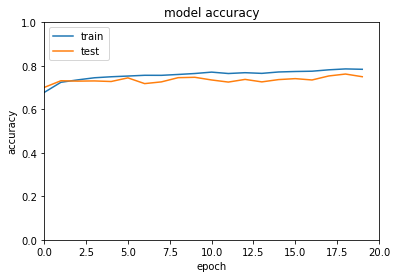

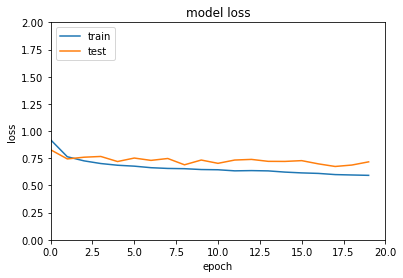

/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


TypeError: Expected sequence or array-like, got <class 'tensorflow.python.keras.engine.sequential.Sequential'>

In [19]:
performance_plots(model, X_test, Y_test, log, nepochs)
df, cm = confusion_matrix(model, X_test, Y_test)
df

### Handle Class Imbalance, Resampling

We can observe a quite significant class imbalance in the data.<br>

One way to compensate for that would be to use resampling.

In [94]:
def handle_imbalance(names, languages):

    ### START YOUR CODE
    l_count = names['lang'].value_counts()
    max_count = max(l_count.tolist())
    
    df = []
    for lang in languages:
        df_lang = names[names['lang'] == lang].sample(max_count, replace=True)
        df.append(df_lang)

    # treat class imbalance
    names_upsampled = pd.concat(df)

    ### END YOUR CODE    
    return names_upsampled

In [96]:
names_upsampled = handle_imbalance(names, languages)
print(names_upsampled['lang'].value_counts())
names_upsampled.groupby('lang')['name'].count()/len(names_upsampled)

Spanish    3668
German     3668
English    3668
Italian    3668
French     3668
Name: lang, dtype: int64


lang
English    0.2
French     0.2
German     0.2
Italian    0.2
Spanish    0.2
Name: name, dtype: float64

#### Train Model

Again prepare train and test data (X_train, X_test, Y_train, Y_test)

Train the same model as above with the new data.

In [97]:
### START YOUR CODE

# Shuffle and split names data
# Map train and test data into vector space (one-hot-vectors)
names_upsampled['name_ohot'] = names_upsampled['name'].apply(lambda x: name_representation(x, maxlen))
names_upsampled['lang_ohot'] = names_upsampled['lang'].apply(lambda x: lang_representation(x, language_to_index))

X = np.stack(names_upsampled['name_ohot'], axis=0)
y = np.stack(names_upsampled['lang_ohot'], axis=0)

print('Shapes, X: {0}, y: {1}'.format(X.shape, y.shape))

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=test_split, shuffle=True, random_state=42)

### END YOUR CODE

Shapes, X: (18340, 18, 74), y: (18340, 5)


In [98]:
### START YOUR CODE

# train model

n_classes = 5
n_hidden_units = 200

model = Sequential()
model.add(Input((maxlen, len_alphabet)))
model.add(SimpleRNN(n_hidden_units))
model.add(Dense(n_classes, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics='accuracy')

batch_size = 32
nepochs = 20

log = model.fit(X_train, Y_train, batch_size=batch_size, \
                epochs=nepochs, validation_data=(X_test, Y_test))

### END YOUR CODE

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_12 (SimpleRNN)    (None, 200)               55000     
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 1005      
Total params: 56,005
Trainable params: 56,005
Non-trainable params: 0
_________________________________________________________________


Train accuracy (end): 0.944656491279602
Train accuracy (max): 0.944656491279602
Test accuracy (end) : 0.919847309589386
Test accuracy (max) : 0.929934561252594


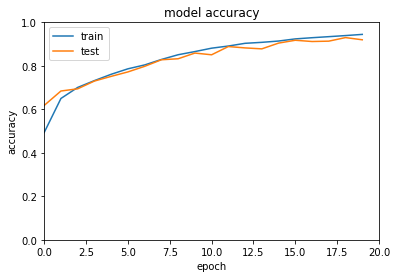

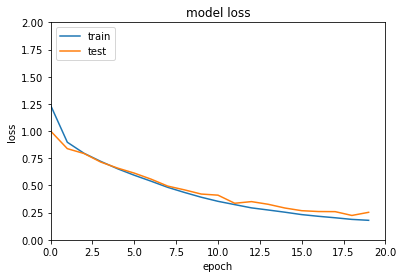

,English,French,Italian,German,Spanish
English,708,1,15,0,3
French,39,601,63,11,13
Italian,20,28,680,3,1
German,22,11,3,691,23
Spanish,2,4,1,31,694


In [100]:
performance_plots(model, X_test, Y_test, log, nepochs)
df, cm = confusion_matrix(model, X_test, Y_test)
df

#### Findings

The model trained on the balanced dataset seems to have much healtier results than the one trained on the unbalanced one. The confusion matrix further shows that there is not one class that is predicted more than the other as it was the case in the unbalanced one. The accuracy on both the train and test set was able to be increased by more than 10%.

#### In which situations is class imbalance treatment important and why?  

When wanting to evaluate the model using the Accuracy its important to treat it. Or also when using SGD we get high gradients pointing to a local optima biased towards the majority class.

### Implement Model with several SimpleRNN Layers

In [101]:
### START YOUR CODE

n_classes = 5
n_hidden_units = 200

model = Sequential()
model.add(Input((maxlen, len_alphabet)))
model.add(SimpleRNN(n_hidden_units, return_sequences=True))
model.add(SimpleRNN(n_hidden_units, return_sequences=True))
model.add(SimpleRNN(n_hidden_units, return_sequences=False))
model.add(Dense(n_classes, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics='accuracy')

### END YOUR CODE

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_13 (SimpleRNN)    (None, 18, 200)           55000     
_________________________________________________________________
simple_rnn_14 (SimpleRNN)    (None, 18, 200)           80200     
_________________________________________________________________
simple_rnn_15 (SimpleRNN)    (None, 200)               80200     
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 1005      
Total params: 216,405
Trainable params: 216,405
Non-trainable params: 0
_________________________________________________________________


In [102]:
### START YOUR CODE

batch_size = 32
nepochs = 20

log = model.fit(X_train, Y_train, batch_size=batch_size, \
                epochs=nepochs, validation_data=(X_test, Y_test))

### END YOUR CODE

Epoch 1/20
459/459 [==============================] - 8s 16ms/step - loss: 1.2470 - accuracy: 0.4870 - val_loss: 0.7289 - val_accuracy: 0.7326
Epoch 2/20
459/459 [==============================] - 7s 16ms/step - loss: 0.6581 - accuracy: 0.7689 - val_loss: 0.5386 - val_accuracy: 0.8206
Epoch 3/20
459/459 [==============================] - 7s 15ms/step - loss: 0.4866 - accuracy: 0.8414 - val_loss: 0.4033 - val_accuracy: 0.8689
Epoch 4/20
459/459 [==============================] - 7s 15ms/step - loss: 0.3622 - accuracy: 0.8841 - val_loss: 0.3297 - val_accuracy: 0.8942
Epoch 5/20
459/459 [==============================] - 7s 15ms/step - loss: 0.2674 - accuracy: 0.9169 - val_loss: 0.2731 - val_accuracy: 0.9179
Epoch 6/20
459/459 [==============================] - 7s 15ms/step - loss: 0.2210 - accuracy: 0.9347 - val_loss: 0.2422 - val_accuracy: 0.9218
Epoch 7/20
459/459 [==============================] - 7s 15ms/step - loss: 0.1795 - accuracy: 0.9451 - val_loss: 0.2076 - val_accuracy: 0.9357

Train accuracy (end): 0.9661940932273865
Train accuracy (max): 0.9664667248725891
Test accuracy (end) : 0.9506543278694153
Test accuracy (max) : 0.9561068415641785


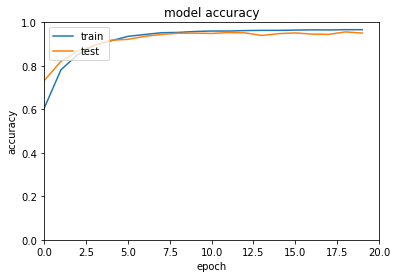

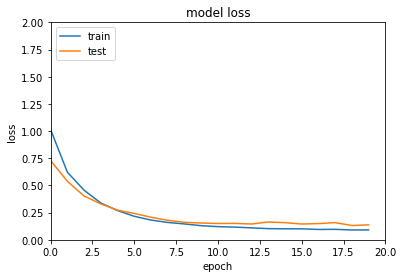

,English,French,Italian,German,Spanish
English,680,10,17,20,0
French,17,669,26,7,8
Italian,10,11,704,7,0
German,0,0,0,720,30
Spanish,1,0,0,17,714


In [103]:
performance_plots(model, X_test, Y_test, log, nepochs)
df, cm = confusion_matrix(model, X_test, Y_test)
df

#### Findings

The accuracy and loss look healthy and the model seems to have converged. From the confusion matrix it can be observed that the model is indeed doing a better job at predicting the correct classes than above and the model is more sure that one class is the correct one. The accuracy of the model was able to be increased by another 5% on the test set. 